In [2]:
import MarsGT 
from MarsGT.conv import *
from MarsGT.egrn import *
from MarsGT.marsgt_model import *
from MarsGT.utils import *
import anndata as ad
from collections import Counter
import copy
import dill
from functools import partial
import json
import math
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import multiprocessing as mp
import numpy as np
import os
import pandas as pd
from operator import itemgetter
import random
import scipy.sparse as sp
from scipy.io import mmread
from scipy.sparse import hstack, vstack, coo_matrix
import seaborn as sb
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import IncrementalPCA
from sklearn.decomposition import SparsePCA
from sklearn.metrics import accuracy_score
from sklearn.metrics.cluster import normalized_mutual_info_score
import time
import torch
import torch.cuda as cuda
from torch import nn
from torch.autograd import Variable
import torch.distributions as D
import torch.nn.functional as F
import torch_geometric.data as Data
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.inits import glorot, uniform
from torch_geometric.utils import softmax as Softmax
from torchmetrics.functional import pairwise_cosine_similarity
import warnings
from warnings import filterwarnings
import xlwt
import argparse
from tqdm import tqdm
import scanpy as sc

## Initialize parameters

In [3]:
filterwarnings("ignore")
seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

parser = argparse.ArgumentParser(description='Training GNN on gene cell graph')
parser.add_argument('--fi', type=int, default=0) # This parameter is used for the benchmark to specify the starting sequence number of the created files
parser.add_argument('--labsm', type=float, default=0.1) # The rate of LabelSmoothing
parser.add_argument('--wd', type=float, default=0.1) # The 'weight_decay' parameter is used to specify the strength of L2 regularization
parser.add_argument('--lr', type=float, default=0.0005) # learning rate
parser.add_argument('--n_hid', type=int, default=104) # The number of layers should be a multiple of 'n_head' in order to make any modifications
parser.add_argument('--nheads', type=int, default=8) # The 'heads' parameter represents the number of attention heads in the attention mechanism
parser.add_argument('--nlayers', type=int, default=3) # The number of layers in network
parser.add_argument('--cell_size', type=int, default=30) # The number of cells per subgraph (batch)
parser.add_argument('--neighbor', type=int, default=20) # The number of neighboring nodes to be selected for each cell in the subgraph
parser.add_argument('--egrn', type=bool, default=True) # Whether to output the Enhancer-Gene regulatory network
parser.add_argument('--output_file', type=str, default='Z:\mtduan\HGT\B_lymphoma\output')
args = parser.parse_args([])

output_file = args.output_file
fi=args.fi
labsm = args.labsm
lr = args.lr
wd = args.wd
n_hid = args.n_hid
nheads = args.nheads
nlayers = args.nlayers
cell_size = args.cell_size
neighbor = args.neighbor
egrn = args.egrn

## Load the data

In [4]:
os.chdir('Z:\mtduan\HGT\B_lymphoma/')
RNA_cell_label = pd.read_csv('Cell_names.tsv', sep='\t', header=None)
gene_peak = ad.read_mtx('Gene_Peak.mtx')
gene_cell = ad.read_mtx('Gene_Cell.mtx')
peak_cell = ad.read_mtx('Peak_Cell.mtx')
gene_names = pd.read_csv('Gene_names.tsv', sep='\t', header=None)
cell_names = pd.read_csv('Cell_names.tsv', sep='\t', header=None)
peak_names = pd.read_csv('Peak_names.tsv', sep='\t', header=None)
print('Files read successfully')

peak_cell.obs_names = peak_names[0]
peak_cell.var_names = cell_names[0]
gene_cell.obs_names = gene_names[0]
gene_cell.var_names = cell_names[0]
gene_peak.obs_names = gene_names[0]
gene_peak.var_names = peak_names[0]

#gene cell
RNA_matrix = gene_cell.X
#peak cell
ATAC_matrix = peak_cell.X
#gene peak
RP_matrix = gene_peak.X
Gene_Peak = gene_peak.X

eGRN = hstack((RNA_matrix.transpose(), ATAC_matrix.transpose()*(RP_matrix.transpose())))
cell_num = RNA_matrix.shape[1]
gene_num = RNA_matrix.shape[0]
peak_num = ATAC_matrix.shape[0]

Files read successfully


In [6]:
if __name__ == "__main__":
    device = torch.device("cuda" if cuda.is_available() else "cpu")
    print('You will use : ',device)
    # clustering result by scanpy
    initial_pre = initial_clustering(RNA_matrix) 
    # number of every cluster
    cluster_ini_num = len(set(initial_pre)) 
    ini_p1 = [int(i) for i in initial_pre] 
    # partite the data into batches
    indices, Node_Ids, dic = batch_select_whole (RNA_matrix, ATAC_matrix, neighbor = [neighbor], cell_size=cell_size)
    n_batch = len(indices)
    
    # Reduce the dimensionality of features for cell, gene, and peak data.
    node_model = NodeDimensionReduction(RNA_matrix, ATAC_matrix, indices, ini_p1, n_hid=n_hid, n_heads=nheads, 
                                        n_layers=nlayers,labsm=labsm, lr=lr, wd=wd, device=device, num_types=3, num_relations=2, epochs=1)
    gnn,cell_emb,gene_emb,peak_emb,h = node_model.train_model(n_batch=n_batch)

    # Instantiate the MarsGT_model
    MarsGT_model = MarsGT(gnn=gnn, h=h, labsm=labsm, n_hid=n_hid, n_batch=n_batch, device=device,lr=lr,wd=wd, num_epochs=1)
    # Train the model
    MarsGT_gnn = MarsGT_model.train_model(indices=indices,RNA_matrix=RNA_matrix, ATAC_matrix=ATAC_matrix, Gene_Peak=Gene_Peak, ini_p1=ini_p1)
    # The result of MarsGT
    MarsGT_result = MarsGT_pred(RNA_matrix, ATAC_matrix, RP_matrix, egrn=egrn, MarsGT_gnn=MarsGT_gnn, indices=indices, 
                        nodes_id=Node_Ids, cell_size=cell_size, device=device, gene_names=gene_names, peak_names=peak_names)
    
    # Save numpy arrays to files
    np.save(output_file + "/Node_Ids.npy", Node_Ids)
    np.save(output_file + "/pred.npy", MarsGT_result['pred_label'])
    np.save(output_file + "/cell_embedding.npy", MarsGT_result['cell_embedding'])

You will use :  cuda
	When the number of cells is less than or equal to 500, it is recommended to set the resolution value to 0.2.
	When the number of cells is within the range of 500 to 5000, the resolution value should be set to 0.5.
	When the number of cells is greater than 5000, the resolution value should be set to 0.8.
         Falling back to preprocessing with `sc.pp.pca` and default params.
We are currently in the process of partitioning the data into batches. Kindly wait for a moment, please.


100%|██████████| 17/17 [00:05<00:00,  3.00it/s]


The training process for the NodeDimensionReduction model has started. Please wait.


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


The training for the NodeDimensionReduction model has been completed.
The training process for the MarsGT model has started. Please wait.


100%|██████████| 17/17 [01:01<00:00,  3.59s/it]


The training for the MarsGT model has been completed.


100%|██████████| 17/17 [00:00<00:00, 37.54it/s]


We are currently performing calculations for EGRN. Please bear with us as this process will take approximately around 10 minutes.
class_num: 3
We are currently conducting filtering and categorization operations.


## Downstream analysis

### Data reading

In [5]:
ip_file = 'Z:\mtduan\HGT\B_lymphoma\data/'
nodes_id = list(np.load(ip_file+'Node_Ids.npy'))
pred_label = list(np.load(ip_file+'pred.npy'))
cell_embedding = np.load(ip_file+'cell_embedding.npy')

final_cell_index = ~np.array((np.array(pred_label)==14) + (np.array(pred_label)==15)+ (np.array(pred_label)==16),dtype='bool')
B_cell_index = np.array((np.array(pred_label)==0)+(np.array(pred_label)==6)+ (np.array(pred_label)==10)+(np.array(pred_label)==13),dtype='bool')

new_cluster_names = ["B","DP", "CD8 T","DP", "CD4 T", "Macrophage", "B", "CD8 T", "CD8 T", "Macrophage","B","CD4 T","CD4 T","B"]
clu_type = np.array(pred_label,dtype='str')
for i in range(14):
    clu_type[clu_type==str(i)]=new_cluster_names[i]
B_cell_index = np.array((np.array(pred_label)==0)+(np.array(pred_label)==6)+ (np.array(pred_label)==10)+(np.array(pred_label)==13),dtype='bool')

### B cell EGRN

In [5]:
## According to manual annotations, we have identified classes 0, 6, 10, and 13 as B cells. 
## We will now focus our research solely on these four cell types.
egrn_df = pd.DataFrame(columns=['gene', 'peak', 'score', 'class'])
pred_lab = np.array(pred_label)[B_cell_index]
pred_RNA_matrix = RNA_matrix[:,nodes_id][:,B_cell_index]
pred_ATAC_matrix = ATAC_matrix[:,nodes_id][:,B_cell_index]

pred_lab[pred_lab==6]=1
pred_lab[pred_lab==10]=2
pred_lab[pred_lab==13]=3
Total_name = [0,1,2,3]

for i in tqdm(range(len(Total_name))):
    Total_gene_peak_score_df,Total_gene_peak_score = small_gene_Peak_Score(pred_lab,pred_RNA_matrix,pred_ATAC_matrix,RP_matrix,gene_names,peak_names,choice_cluser=i)
    Total_gene_peak_score_df = Total_gene_peak_score_df[Total_gene_peak_score_df['score'] > 0]
    Total_gene_peak_score_df['class'] = Total_name[i]
    egrn_df = egrn_df.append(Total_gene_peak_score_df.sort_values(by="score",ascending=False))

100%|██████████| 4/4 [57:16<00:00, 859.03s/it]


In [6]:
egrn_df

,gene,peak,score,class
694325634,GRAMD1B,chr11:123580275-123581160,221.927308,0
1054430938,MALAT1,chr11:65497145-65498035,129.176315,0
694325633,GRAMD1B,chr11:123576846-123577712,110.576056,0
694325635,GRAMD1B,chr11:123590247-123591057,99.37668,0
2018573877,ZCCHC7,chr9:37119943-37120875,32.754754,0
...,...,...,...,...
2066498387,ZNF576,chr19:43446745-43447635,0.0,3
1401816433,PPP1R36,chr14:64698745-64699719,0.0,3
2063751222,ZNF554,chr19:2670170-2671008,0.0,3
106123694,ARIH2OS,chr3:48769600-48770510,0.0,3


### Plot（Umap+Dotplot）

#### Dotplot_Total

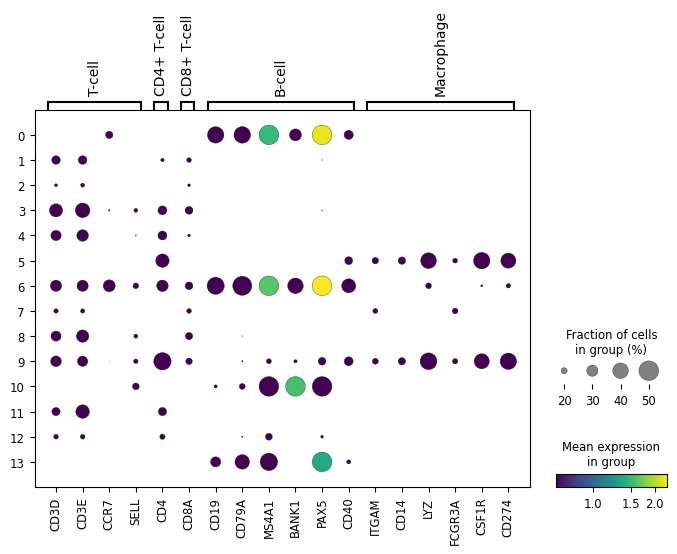

In [11]:
os.chdir('/fs/ess/PCON0022/DMT/B_cell_lymphoma/update_plot/')
import anndata as ad
#adata =  ad.AnnData(eGRN, dtype='int32')
adata =  ad.AnnData(RNA_matrix.transpose(), dtype='int32')[nodes_id][final_cell_index]
adata.var_names=gene_names[0]
# adata.var_names=Gene_Cell.obs_names
# sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
# sc.pp.scale(adata,max_value=10)

# adata.obs['cell_type'] = combine_name
# adata.obs['cell_type'] = adata.obs['cell_type'].astype("category")
adata.obs['pred_type'] = np.array(pred_label)[final_cell_index]
adata.obs['pred_type'] = adata.obs['pred_type'].astype("category")

marker_genes_dict = {'T-cell':['CD3D', 'CD3E','CCR7','SELL'],
                     'CD4+ T-cell':['CD4'],
                     'CD8+ T-cell':['CD8A'],
                    'B-cell':['CD19', 'CD79A', 'MS4A1','BANK1','PAX5','CD40'],
                    'Macrophage':['ITGAM','CD14','LYZ','FCGR3A','CSF1R','CD274']
                    }
#                      'DSLL':['CD19','MS4A1','CD79B','FCRLA','FCRL2'],
#                      'DSLL state-1':['BCL2','BACH2'],
#                      'DSLL state-2':['BCL6','CDK4','PCNA','TK1','MKI67'],
# sc.pl.dotplot(adata,marker_genes_dict,groupby='pred_type',color_map='Blues')
sc.pl.dotplot(adata,marker_genes_dict,groupby='pred_type',color_map='viridis',dot_max=0.5,dot_min=0.12,vmin=0.8,vcenter=1.1)

#### Umap_total

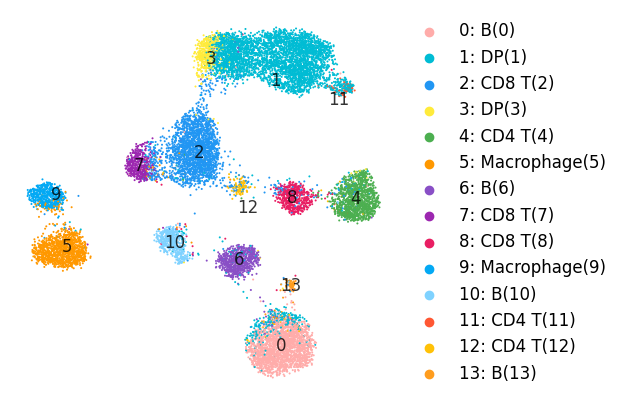

In [12]:
import anndata as ad
import matplotlib.pyplot as plt
import numpy as np

adata = ad.AnnData(RNA_matrix.transpose()[nodes_id][final_cell_index], dtype='int32')
adata.var_names = gene_names[0]

adata.obs['pred_type'] = np.array(pred_label)[final_cell_index]
adata.obs['pred_type'] = adata.obs['pred_type'].astype("category")

adata.obs['clu_type'] = np.array(clu_type)[final_cell_index]
adata.obs['clu_type'] = adata.obs['clu_type'].astype("category")

adata.uns['clu_type_colors'] = [
    "#FFACAA", "#7FD2FF", "#FF9D1E", "#894FC6", "#FF5733",
    "#FFC107", "#4CAF50", "#2196F3", "#9C27B0",
    "#E91E63", "#00BCD4", "#FFEB3B", "#FF9800", "#03A9F4"
]
adata.obsm['cell_emb'] = cell_embedding[final_cell_index]

sc.pp.neighbors(adata, use_rep='cell_emb')
sc.tl.umap(adata)

clu_type_names = np.array(clu_type)[final_cell_index]
adata.obs['pred_type_name'] = np.array([f"{x}: {clu_type_names[i]}" for i, x in enumerate(adata.obs['pred_type'])])
adata.obs['pred_type_name'] = adata.obs['pred_type_name'].astype("category")

# Reorder the categories in pred_type_name
sorted_categories = sorted(adata.obs['pred_type_name'].cat.categories, key=lambda x: int(x.split(':')[0]))
adata.obs['pred_type_name'] = adata.obs['pred_type_name'].cat.reorder_categories(sorted_categories)

# Update adata.uns['pred_type_name_colors'] based on the new order
clu_type_to_color = dict(zip(adata.obs['clu_type'].cat.categories, adata.uns['clu_type_colors']))
pred_type_name_to_clu_type_colors = {x: clu_type_to_color[x.split(': ')[1]] for x in adata.obs['pred_type_name'].cat.categories}
adata.uns['pred_type_name_colors'] = [pred_type_name_to_clu_type_colors[x] for x in adata.obs['pred_type_name'].cat.categories]

# Plot the UMAP with the updated legend order
with plt.rc_context({'figure.figsize': (5, 5)}):
    fig, ax = plt.subplots()
    sc.pl.umap(adata, color=['pred_type_name'], add_outline=False,
               legend_fontsize=12, legend_fontoutline=5, frameon=False, title='',
               use_raw=False, color_map=None, ax=ax, show=False)
    
    # Add labels to the UMAP plot
    for category in adata.obs['pred_type_name'].cat.categories:
        coords = adata.obsm['X_umap'][adata.obs['pred_type_name'] == category]
        center = coords.mean(axis=0)
        ax.text(center[0], center[1], category.split(':')[0], fontsize=12,
                ha='center', va='center', color='black', alpha=0.8)
    plt.show()

#### Dotplot_Bcell

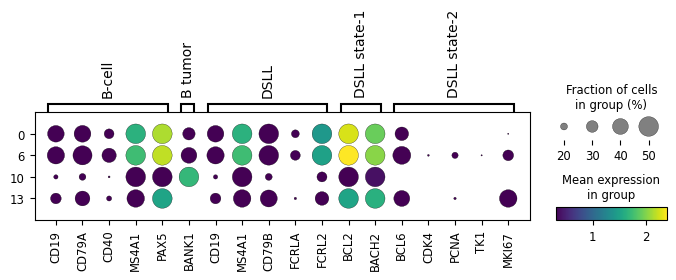

In [13]:
import anndata as ad
#adata =  ad.AnnData(eGRN, dtype='int32')
adata =  ad.AnnData(RNA_matrix.transpose(), dtype='int32')[nodes_id][B_cell_index]
adata.var_names=gene_names[0]
# adata.var_names=Gene_Cell.obs_names
# sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
# sc.pp.scale(adata,max_value=10)

# adata.obs['cell_type'] = combine_name
# adata.obs['cell_type'] = adata.obs['cell_type'].astype("category")
adata.obs['pred_type'] = np.array(pred_label)[B_cell_index]
adata.obs['pred_type'] = adata.obs['pred_type'].astype("category")

marker_genes_dict = {'B-cell':['CD19', 'CD79A','CD40','MS4A1','PAX5'],
                     'B tumor':['BANK1'],
                     'DSLL':['CD19','MS4A1','CD79B','FCRLA','FCRL2'],
                     'DSLL state-1':['BCL2','BACH2'],
                     'DSLL state-2':['BCL6','CDK4','PCNA','TK1','MKI67']
                     }
sc.pl.dotplot(adata,marker_genes_dict,groupby='pred_type',color_map='viridis',dot_max=0.5,dot_min=0.1,vmin=0.8,vcenter=1.1)

#### Umap_Bcell

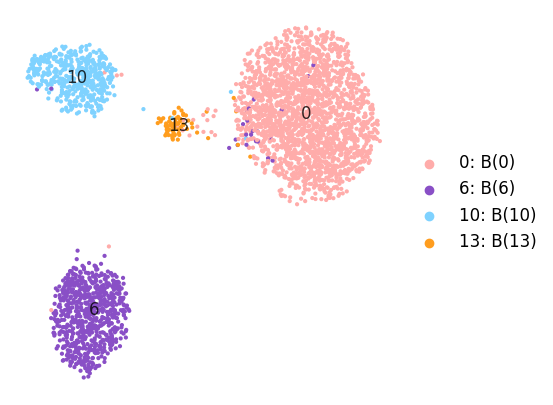

In [14]:
new_cluster_names = ["B(0)","DP(1)", "CD8 T(2)","DP(3)", "CD4 T(4)", "Macrophage(5)", "B(6)", "CD8 T(7)", "CD8 T(8)", "Macrophage(9)","B(10)","CD4 T(11)","CD4 T(12)","B(13)","B(14)"]
clu_type = np.array(pred_label,dtype='str')
for i in range(15):
    clu_type[clu_type==str(i)]=new_cluster_names[i]
import anndata as ad
#adata =  ad.AnnData(eGRN, dtype='int32')
adata =  ad.AnnData(RNA_matrix.transpose()[nodes_id][B_cell_index], dtype='int32')
adata.var_names=gene_names[0]
# adata.var_names=Gene_Cell.obs_names
# sc.pp.normalize_total(adata, target_sum=1e4)
# sc.pp.log1p(adata)

adata.obs['pred_type'] = np.array(pred_label)[B_cell_index]
adata.obs['pred_type'] = adata.obs['pred_type'].astype("category")

adata.obs['clu_type'] = np.array(clu_type)[B_cell_index]
adata.obs['clu_type'] = adata.obs['clu_type'].astype("category")
adata.uns['clu_type_colors'] = [ "#FFACAA","#7FD2FF","#FF9D1E", "#894FC6"]

adata.obsm['cell_emb'] = cell_embedding[B_cell_index]

sc.pp.neighbors(adata, use_rep='cell_emb')
sc.tl.umap(adata)

clu_type_names = np.array(clu_type)[B_cell_index]
adata.obs['pred_type_name'] = np.array([f"{x}: {clu_type_names[i]}" for i, x in enumerate(adata.obs['pred_type'])])
adata.obs['pred_type_name'] = adata.obs['pred_type_name'].astype("category")

# Reorder the categories in pred_type_name
sorted_categories = sorted(adata.obs['pred_type_name'].cat.categories, key=lambda x: int(x.split(':')[0]))
adata.obs['pred_type_name'] = adata.obs['pred_type_name'].cat.reorder_categories(sorted_categories)

# Update adata.uns['pred_type_name_colors'] based on the new order
clu_type_to_color = dict(zip(adata.obs['clu_type'].cat.categories, adata.uns['clu_type_colors']))
pred_type_name_to_clu_type_colors = {x: clu_type_to_color[x.split(': ')[1]] for x in adata.obs['pred_type_name'].cat.categories}
adata.uns['pred_type_name_colors'] = [pred_type_name_to_clu_type_colors[x] for x in adata.obs['pred_type_name'].cat.categories]

# Plot the UMAP with the updated legend order
with plt.rc_context({'figure.figsize': (5, 5)}):
    fig, ax = plt.subplots()
    sc.pl.umap(adata, color=['pred_type_name'], add_outline=False,
               legend_fontsize=12, legend_fontoutline=5, frameon=False, title='',
               use_raw=False, color_map=None, ax=ax, show=False)
    
    # Add labels to the UMAP plot
    for category in adata.obs['pred_type_name'].cat.categories:
        coords = adata.obsm['X_umap'][adata.obs['pred_type_name'] == category]
        center = coords.mean(axis=0)
        ax.text(center[0], center[1], category.split(':')[0], fontsize=12,
                ha='center', va='center', color='black', alpha=0.8)
    plt.show()

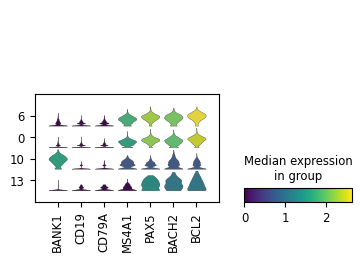

In [27]:
B_cell_index = np.array((np.array(pred_label)==0)+(np.array(pred_label)==6)+ (np.array(pred_label)==10)+(np.array(pred_label)==13),dtype='bool')
adata =  ad.AnnData(RNA_matrix.transpose(), dtype='int32')[nodes_id][B_cell_index]
adata.var_names=gene_names[0]
# sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

adata.obs['pred_type'] = np.array(pred_label)[B_cell_index]
adata.obs['pred_type'] = adata.obs['pred_type'].astype("category")

markers = ['BANK1','CD19','CD79A','MS4A1','PAX5','BACH2','BCL2']
sc.pl.stacked_violin(adata, markers, groupby='pred_type', cmap='viridis', rotation=90, categories_order=[6, 0, 10, 13])

## EGRN

In [ ]:
new_cluster_names = ["B","DP", "CD8 T","DP", "CD4 T", "Macrophage", "B", "CD8 T", "CD8 T", "Macrophage","B","CD4 T","CD4 T","B"]
clu_type = np.array(pred_label,dtype='str')
for i in range(14):
    clu_type[clu_type==str(i)]=new_cluster_names[i]
B_cell_index = np.array((np.array(pred_label)==0)+(np.array(pred_label)==6)+ (np.array(pred_label)==10)+(np.array(pred_label)==13),dtype='bool')

In [29]:
def gene_Peak_Score(pred_label,RNA_matrix,ATAC_matrix,gene_names,peak_names,choice_cluser):  
    y = ad.AnnData(RNA_matrix.transpose(), dtype='int32')
    y.var_names=gene_names[0]
    y.obs['pred'] = np.array(pred_label,dtype='int64')
    y.obs['pred'] = y.obs['pred'].astype("category")
    ## 把预测结果存储为稀疏矩阵，行代表细胞，列代表聚类标签 对应位置为1表示该细胞属于该类
    cell_emb_binary = sp.coo_matrix((np.ones(len(y.obs['pred'])),(np.array(range(len(y.obs['pred']))),list(y.obs['pred']))))
    cell_emb_binary.todense()

    adata_atac_all = ATAC_matrix
    adata_rna_all = RNA_matrix

    ATAC_matrix_ct = adata_atac_all*(cell_emb_binary)
    RNA_matrix_ct = adata_rna_all*(cell_emb_binary)
    
    RNA_matrix_ct = RNA_matrix_ct/np.sum(cell_emb_binary,axis=0)
    ATAC_matrix_ct = ATAC_matrix_ct/np.sum(cell_emb_binary,axis=0)

    rna_matrix = RNA_matrix_ct
    m = range(rna_matrix.shape[0])
    gene_peak = RP_matrix
    gp = gene_peak.reshape(gene_peak.shape[1]*rna_matrix.shape[0],1).todense()
    gene_emb_enh = ATAC_matrix_ct[list(range (ATAC_matrix_ct.shape[0]))*rna_matrix.shape[0]]
    peak_emb_enh = RNA_matrix_ct[[v for v in m for i in range(ATAC_matrix_ct.shape[0])]]
    egrn = np.multiply(gene_emb_enh, peak_emb_enh)
    print(egrn.shape)
    print(gp.shape)
    egrn = np.multiply(egrn,gp)
    
    gn = np.array(gene_names[0])[[v for v in m for i in range(ATAC_matrix.shape[0])]]
    pn = np.array(peak_names[0])[list(range (ATAC_matrix.shape[0]))*RNA_matrix.shape[0]]
    data = np.array(np.squeeze(egrn[:,choice_cluser]))[0]
    
    gene_peak_score_Dict = {'gene': gn, 'peak': pn, 'score':data}
    gene_peak_score_df = pd.DataFrame(data = gene_peak_score_Dict)
    gene_peak_score = gene_peak_score_df[gene_peak_score_df['score'] > 0]
    gene_peak_score = gene_peak_score.drop_duplicates(['gene','peak'])
    gene_peak_score = gene_peak_score.sort_values(by="score",ascending=False)
    
    print(gene_peak_score.head())
    
    return gene_peak_score_df,gene_peak_score

In [31]:
pred_lab = np.array(pred_label)[B_cell_index]
pred_RNA_matrix = RNA_matrix[:,nodes_id][:,B_cell_index]
pred_ATAC_matrix = ATAC_matrix[:,nodes_id][:,B_cell_index]
pred_lab[pred_lab==6]=1
pred_lab[pred_lab==10]=2
pred_lab[pred_lab==13]=3

Total_socre_df = pd.DataFrame(columns=['gene', 'peak', 'score', 'class'])
Total_name = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]
Total_name = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]
Total_name = [0,1,2,3]
for i in range(4):
    Total_gene_peak_score_df,Total_gene_peak_score = gene_Peak_Score(pred_lab,pred_RNA_matrix ,pred_ATAC_matrix ,gene_names,peak_names,choice_cluser=i)
    Total_gene_peak_score_df = Total_gene_peak_score_df[Total_gene_peak_score_df['score'] > 0]
    Total_gene_peak_score_df['class'] = Total_name[i]
    Total_socre_df = Total_socre_df.append(Total_gene_peak_score_df.sort_values(by="score",ascending=False))

(2097738423, 4)
(2097738423, 1)
               gene                       peak       score
694325634   GRAMD1B  chr11:123580275-123581160  221.927308
1054430938   MALAT1    chr11:65497145-65498035  129.176315
694325633   GRAMD1B  chr11:123576846-123577712  110.576056
694325635   GRAMD1B  chr11:123590247-123591057   99.376680
2018573877   ZCCHC7     chr9:37119943-37120875   32.754754
(2097738423, 4)
(2097738423, 1)
               gene                       peak       score
1054430938   MALAT1    chr11:65497145-65498035  392.195473
694325634   GRAMD1B  chr11:123580275-123581160  387.402010
694325635   GRAMD1B  chr11:123590247-123591057  229.814205
694325633   GRAMD1B  chr11:123576846-123577712  227.378534
1054430936   MALAT1    chr11:65477131-65478049   60.011562
(2097738423, 4)
(2097738423, 1)
              gene                     peak      score
1054430938  MALAT1  chr11:65497145-65498035  14.654368
2040468564  ZNF232    chr17:5237225-5238107   5.839502
2040468561  ZNF232    chr17:522

In [35]:
Total_socre_df.loc[Total_socre_df['gene']=='STAT1',:]

,gene,peak,score,class
1741530210,STAT1,chr2:191013783-191014702,1.161195,0
1741530215,STAT1,chr2:191030345-191031207,0.039285,0
1741530209,STAT1,chr2:191003470-191004164,0.02542,0
1741530207,STAT1,chr2:190984544-190985402,0.011035,0
1741530214,STAT1,chr2:191029150-191029855,0.010111,0
...,...,...,...,...
1741530201,STAT1,chr2:190889426-190890364,0.00002,3
1741530227,STAT1,chr2:191126257-191127090,0.000013,3
1741530228,STAT1,chr2:191128050-191128888,0.000012,3
1741530231,STAT1,chr2:191155307-191156196,0.000008,3


In [36]:
Total_socre_df.loc[Total_socre_df['gene']=='BCL2',:]

,gene,peak,score,class
158032803,BCL2,chr18:63319757-63320675,23.168329,0
158032802,BCL2,chr18:63317821-63318709,8.270115,0
158032801,BCL2,chr18:63312714-63313504,4.022343,0
158032800,BCL2,chr18:63311355-63312237,3.465467,0
158032796,BCL2,chr18:63292654-63293569,2.078746,0
...,...,...,...,...
158032779,BCL2,chr18:63187765-63188525,0.000273,3
158032774,BCL2,chr18:63175087-63175933,0.000208,3
158032775,BCL2,chr18:63180311-63180721,0.000091,3
158032778,BCL2,chr18:63186930-63187625,0.000067,3


In [34]:
Total_socre_df.loc[Total_socre_df['gene']=='HIF1A',:]

,gene,peak,score,class
733969804,HIF1A,chr14:61694932-61695818,1.175648,0
733969800,HIF1A,chr14:61670845-61671695,0.035952,0
733969802,HIF1A,chr14:61679943-61680747,0.030024,0
733969798,HIF1A,chr14:61662220-61663084,0.029991,0
733969801,HIF1A,chr14:61678428-61679430,0.01968,0
...,...,...,...,...
733969789,HIF1A,chr14:61601967-61602805,0.00002,3
733969786,HIF1A,chr14:61594102-61595018,0.000012,3
733969780,HIF1A,chr14:61552681-61553554,0.000009,3
733969818,HIF1A,chr14:61837297-61838131,0.000001,3
